<a href="https://colab.research.google.com/github/Hedredo/dagshub_p7/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How-To MLflow**

**How to use MLflow to log params and metrics**

```
with mlflow.start_run():
  # Your training code here...
  mlflow.log_metric('accuracy', 42)
  mlflow.log_param('Param name', 'Value')
```


**Turn on autologging for most popular ML frameworks**<br>
For more info and list of supported frameworks, see: https://mlflow.org/docs/latest/tracking.html#automatic-logging<br>



```
mlflow.autolog()
```



# **Configuration de l'environnement**

In [230]:
import dagshub
import mlflow
import warnings
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [231]:
# Check if GPU and CUDA are available
gpu = tf.config.list_physical_devices('GPU')
cuda = torch.cuda.is_available()
print("Tensorflow framework: GPU is", "available" if gpu else "NOT AVAILABLE")
print("Pytorch framework: CUDA is", "available" if cuda else "NOT AVAILABLE")

Tensorflow framework: GPU is NOT AVAILABLE
Pytorch framework: CUDA is NOT AVAILABLE


In [232]:
# Remove FutureWarning alerts
warnings.filterwarnings('ignore', category=FutureWarning)

# Initialize dagshub repo
dagshub.init(repo_owner='hedredo', repo_name='dagshub_p7', mlflow=True)

# Set a random seed
SEED = 314
np.random.seed(SEED)
print("Random seed set to", SEED)

Initialized MLflow to track repo "hedredo/dagshub_p7"

Repository hedredo/dagshub_p7 initialized!

Random seed set to 314


# **Chargement des données**

In [233]:
# Path to the csv file
path = "./data/raw/training.1600000.processed.noemoticon.csv"

In [234]:
# Read the file
df = pd.read_csv(
    path,
    header=None,
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    usecols=['target', 'ids', 'date', 'user', 'text'], # remove flag column
    parse_dates=['date'],
    encoding='utf-8',
    encoding_errors='replace' # replace the errors with unicode symbol � (U+FFFD)
    ).sort_values(by='date', ascending=True)

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 799999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB


In [236]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the desired columns
for col in ['ids', 'user']:
    df[col] = encoder.fit_transform(df[col])

# Replace 4 with 1 in the target column
df['target'] = df['target'].replace(4, 1)

# Finally, create new columns for month, day, and hour and drop date
df = df.assign(**{
    'month': lambda x: x.date.transform(lambda x: x.month),
    'day': lambda x: x.date.transform(lambda x: x.day),
    'hour': lambda x: x.date.transform(lambda x: x.hour),
}).drop(columns=['date'])

In [237]:
# Convert the datatypes to save memory
df = df.astype({
    'target': 'int8',
    'ids': 'int32',
    'user': 'int32',
    'month': 'int8',
    'day': 'int8',
    'hour': 'int8'
})

In [238]:
df.head()

,target,ids,user,text,month,day,hour
0,0,0,242711,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,6,22
1,0,1,577449,is upset that he can't update his Facebook by ...,4,6,22
2,0,2,490699,@Kenichan I dived many times for the ball. Man...,4,6,22
3,0,3,65794,my whole body feels itchy and like its on fire,4,6,22
4,0,4,113308,"@nationwideclass no, it's not behaving at all....",4,6,22


In [239]:
print(df.duplicated().sum(), "duplicata trouvé.")
print(df.duplicated(subset=['ids', 'target', 'text']).sum(), "duplicata trouvé sur les colonnes ids, target et text.")

0 duplicata trouvé.
0 duplicata trouvé sur les colonnes ids, target et text.


In [240]:
print("Nombre de tweets uniques: ", df['ids'].nunique())
print("Nombre de tweets annotés à la fois positivement et négativement: ", df['ids'].size - df['ids'].nunique())

Nombre de tweets uniques:  1598315
Nombre de tweets annotés à la fois positivement et négativement:  1685


On doit retirer ces tweets qui ont deux valeurs car cela va complexifier la capacité du modèle a bien séparé les classes s'ils sont ambiguës.<br>
Regardons un exemple de tweet avec deux valeurs:

In [241]:
print(df.loc[df['ids'].duplicated(), 'text'].sample(1).values)

["@elishacuthbert Hi! It's nice to see you Twittering.  It is hot as hell here in Arizona. "]


In [242]:
df = df.drop_duplicates(subset=['ids'], keep=False)
print("Nouvelle taille du jeu de données après suppression des duplicata sur ids: ", len(df))

Nouvelle taille du jeu de données après suppression des duplicata sur ids:  1596630


In [243]:
# Display the summary statistics of numerical columns
with pd.option_context(
    'display.max_colwidth', 100,
    'display.float_format', '{:.2f}'.format
    ):
    display(df.describe())

,target,ids,user,month,day,hour
count,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00
mean,0.50,799301.29,330323.25,5.51,14.81,10.96
std,0.50,461450.15,191341.79,0.61,9.79,7.22
min,0.00,0.00,0.00,4.00,1.00,0.00
25%,0.00,399669.25,164668.00,5.00,6.00,5.00
50%,0.50,799342.50,329997.00,6.00,16.00,10.00
75%,1.00,1199004.75,496888.75,6.00,21.00,18.00
max,1.00,1598314.00,659774.00,6.00,31.00,23.00


In [244]:
# Statistics of the number of tweets per user
df['user'].value_counts().describe()

count    659502.000000
mean          2.420963
std           4.697115
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

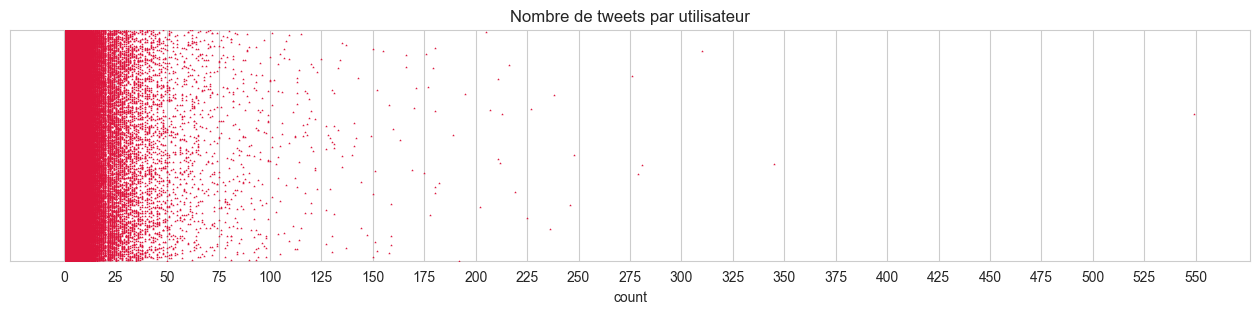

In [245]:
# Show a stripplot of the number of tweets per user
fig, ax = plt.subplots(figsize=(16, 3))
sns.stripplot(
    x=df['user'].value_counts(),
    jitter=0.5,
    size=2,
    marker='*',
    color='crimson',
    ax=ax)
ax.set_title("Nombre de tweets par utilisateur")
ax.set_xticks(range(0, 575, 25))
plt.show()

Un nombre très limité d'utilisateurs tweet énormément alors que la moyenne sur le jeu de données est de 2,4 tweets par utilisateur.<br>
Il n'est pas possible de prendre en compte cette variable dans le modèle car elle peut introduire un biais par ces utilisateurs qui tweentent beaucoup.<br>

In [246]:
# Creation of a palette with 2 colors, crimson and deepskyblue
palette = sns.color_palette(['crimson', 'deepskyblue'])

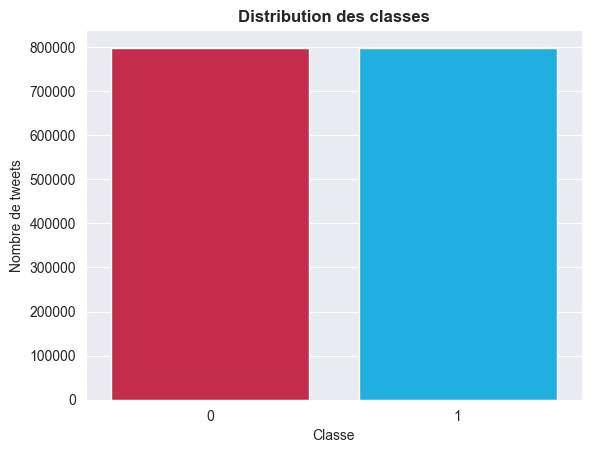

In [247]:
with sns.axes_style('darkgrid'):    
    sns.countplot(df, x='target', palette=palette)
    plt.title("Distribution des classes", fontweight='bold')
    plt.xlabel("Classe")
    plt.ylabel("Nombre de tweets")
    plt.show()

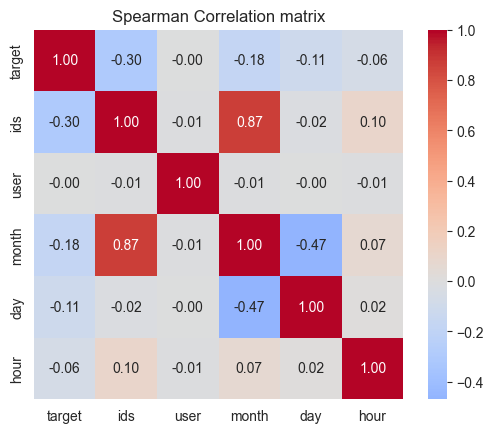

In [248]:
sns.heatmap(
    df.select_dtypes(exclude=['object']).corr('spearman'),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True)
plt.title("Spearman Correlation matrix")
plt.show()

On note une forte corrélation entre les ids des tweets et le mois. Les deux valeurs étant incrémentales positivement, elles sont logiquement corrélées.<br>
La relation négative négative entre la target et les ids des tweets est également logique, car les tweets les plus récents sont plus susceptibles d'être des tweets de haine.

In [249]:
# Creation of a palette with 2 colors, crimson and deepskyblue
palette = sns.color_palette(['crimson', 'deepskyblue'])

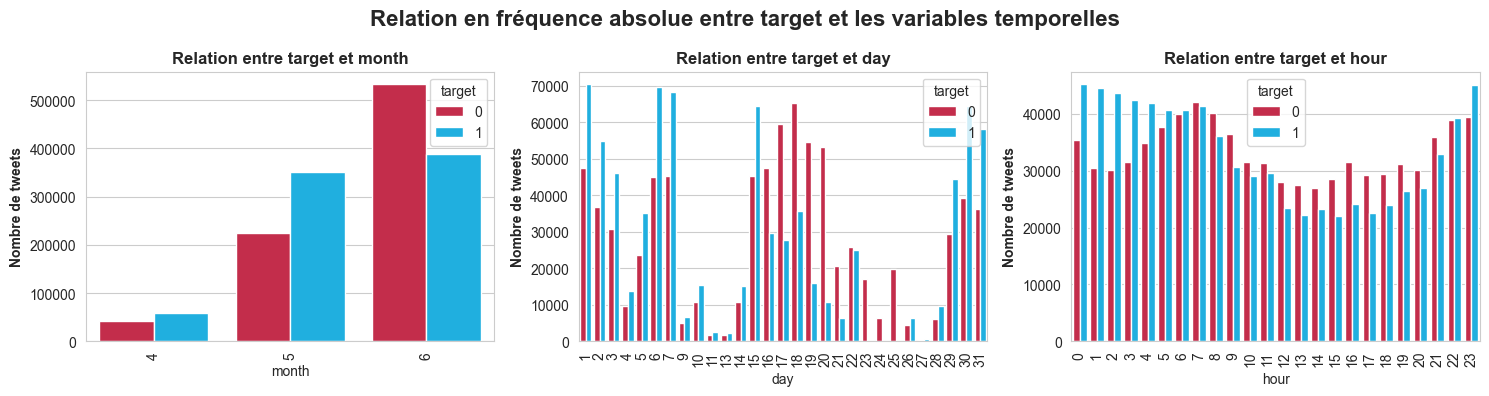

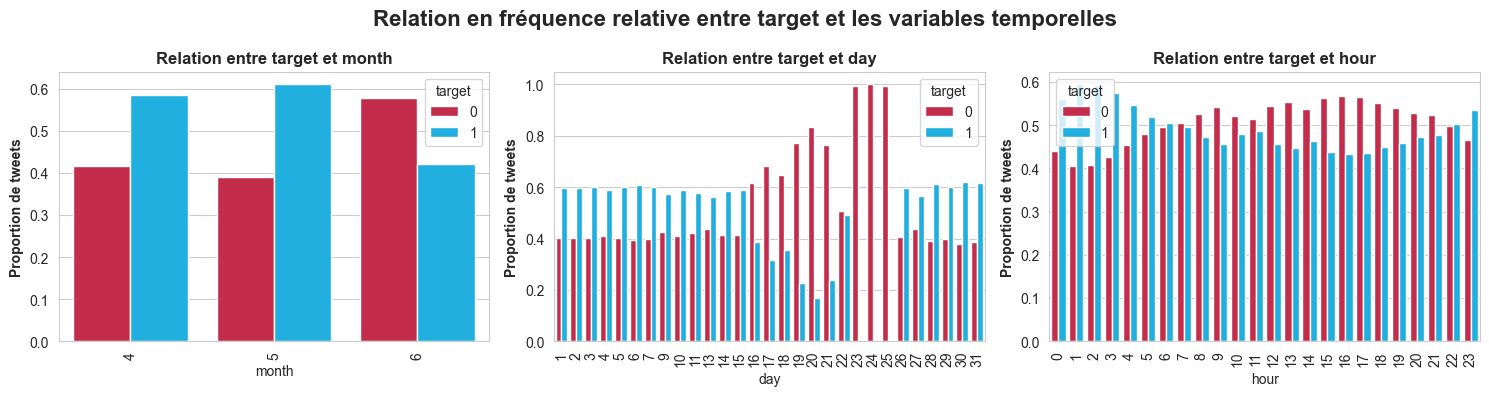

In [250]:
# Display the relation between target and the variables month, day, and hour
for title, method in zip(('absolue', 'relative'), ('count', 'proportion')):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False, tight_layout=True)
    fig.suptitle(f"Relation en fréquence {title} entre target et les variables temporelles", fontweight='bold', fontsize=16)
    sns.set_style('whitegrid')
    for i, col in enumerate(['month', 'day', 'hour']):
        sns.barplot(
            df.groupby(col)['target'].value_counts(normalize=True if title=='relative' else False).reset_index(),
            x=col,
            y=method,
            hue='target',
            palette=palette,
            ax=ax[i])
        ax[i].set_title(f"Relation entre target et {col}", fontweight='bold')
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Proportion de tweets' if title=='relative' else 'Nombre de tweets' , fontweight='bold')
        ax[i].set_xticks(ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    plt.show()

On peut noter que **certaines journées ne sont pas présentes (le 8 et le 12)**.<br>
Pour une raison inconnue, les jours 23, 24 et 25 sont uniquement **négatifs**.<br>
La répartition des tweets n'est pas uniforme **sur les mois**, avec une concentration beaucoup plus forte en mai (+ de positif) et en juin (+ de négatif) qu'en avril avec la faible relation linéaire négative identifiée dans la matrice de corrélation.<br>

On identifie deux relations non linéaires à:
- **l'échelle journalière**: Les tweets négatifs sont plus fréquents en milieu de mois et les tweets positifs en début et fin de mois.
- **l'échelle horaire**: on a un cycle en forme d'ADN, la nuit étant plus propice aux tweets positifs, la tendance s'inversant durant la matinée avant de voir l'après-midi plus propice aux tweets négatifs


Dans l'absolu, **seule la variable horaire semble avoir un lien avec la target**. Les autres variables sont  biaisées par leur fréquence relative déséquilibrée.

In [251]:
# Sélection de données restreintes
df = df.filter(['target', 'text', 'hour'])

# Assign the len of the preprocessed dataframe
n_rows = len(df)

# **Séparation des données**

In [252]:
# Define if working with a sample
sampling = True
proportion = 0.1

# Split the data with sampling or not
if sampling:
    if len(df) != n_rows:
        print("Dataframe has already been sampled")
    else:
        print(f"Sampling the data with {proportion} fraction")
        df = df.sample(frac=proportion, random_state=SEED)

# Define X and y
X = df['text']
y = df['target']

# Split the data with a 0.2 test size
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
    )

# Display shape of splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Sampling the data with 0.1 fraction
X_train shape: (127730,)
X_test shape: (31933,)
y_train shape: (127730,)
y_test shape: (31933,)


# **Options de standardisation des textes**

Voici une liste de 10 moyens de standardiser votre corpus de tweets pour l'analyse de sentiments :

1. **Conversion en minuscules** : Transformer tous les caractères en minuscules pour uniformiser le texte.
2. **Suppression de la ponctuation** : Enlever tous les signes de ponctuation qui peuvent ne pas être pertinents pour l'analyse.
3. **Élimination des mots vides (stop words)** : Supprimer les mots courants qui n'ajoutent pas de valeur sémantique significative (comme "le", "la", "de", etc.).
4. **Stemming** : Réduire les mots à leur racine pour traiter les variations morphologiques (par exemple, "aimant", "aimer", "aimé" deviennent "aim").
5. **Lemmatisation** : Transformer les mots en leur forme de base ou canonique (par exemple, "étudiants" devient "étudiant").
6. **Suppression des nombres** : Enlever les chiffres qui peuvent ne pas être utiles pour l'analyse de sentiments.
7. **Traitement des URL** : Remplacer les liens par un token spécifique comme `<URL>` pour uniformiser le texte.
8. **Gestion des mentions** : Remplacer les @utilisateur par un token comme `<MENTION>` pour éviter les informations spécifiques inutiles.
9. **Traitement des hashtags** : Extraire le mot-clé du hashtag (par exemple, "#bonheur" devient "bonheur") pour conserver le sens.
10. **Gestion des emojis et émoticônes** : Remplacer les emojis par leur signification textuelle ou les supprimer si nécessaire (par exemple, "😊" devient "heureux").

Ces standardisations peuvent vous aider à améliorer la qualité de vos données et potentiellement les performances de vos modèles de classification en réduisant le bruit et en uniformisant le corpus.

In [43]:
# Load a spacy model of your choice
spacy_model = 'en_core_web_sm'
disable = ['ner']

# Check if gpu is available to use it with spacy
if gpu:
    spacy.prefer_gpu()

# Load the model without the ner component and download it if needed
try:
    nlp = spacy.load(spacy_model, disable=disable)
except OSError as e:
    print(e)
    print(f"Downloading the {spacy_model} model...")
    spacy.cli.download(spacy_model)
    # Add sleep time
    time.sleep(5)
    # Finally load the model
    print("Loading the model...")
    nlp = spacy.load(spacy_model, disable=disable)
finally:
    print(f"{spacy_model.upper()} model loaded successfully :)")
    print(f"Model components: {nlp.pipe_names}")


EN_CORE_WEB_SM model loaded successfully :)
Model components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


**EDA**

* Longueur str
* Nombre de tokens
* Longueur moyenne / min / max / std token
* Compte le nombre d'erreurs unidecode
* Compte le nombre de tags
* Comptre le nombre de hashtags
* Compte le nombre de mentions
* Compte le nombre d'emoji
* Compte le nombre d'URL
* Regarder textastic/chatgpt/ pour l'argot et les abréviations
* Etc...

In [15]:
def preprocess_text(
        text:str,
        lowercase:bool=True,
        root:str='raw',
        rm_punct:bool=True,
        rm_stopwords:bool=True,
        rm_numbers:bool=True,
        rm_url:bool=True,
        rm_mention:bool=True,
        rm_hashtag:bool=True,
        rm_emoji:bool=True
        ):
    # Root error management
    match root:
        case 'lemma'|'stem'|'raw':
            pass
        case _:
            raise ValueError("root must be 'lemma', 'stem' or 'raw'")

    # TO WRITE


    # Return the preprocessed text
    return text

In [16]:
text = X_train.sample(1).values[0]
print(text)

So far, most Habbos would want to dance to &quot;Love Story&quot; (Taylor Swift) or &quot;Tonight I Celebrate My Love&quot; (Roberta Flack). Amusing. 


In [17]:
preprocess_text(text)

'So far, most Habbos would want to dance to &quot;Love Story&quot; (Taylor Swift) or &quot;Tonight I Celebrate My Love&quot; (Roberta Flack). Amusing. '

In [ ]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de caractères dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = text_df[column].str.len()
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de caractères', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de caractères', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()
    

In [1]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('text', ),
    ('deepskyblue', ),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = pd.Series([len(doc) for doc in nlp.pipe(df[column].values)])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de tokens', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution de la longueur des tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule la longueur de chaque token pour chaque produit
    series = pd.Series([len(token) for doc in nlp.pipe(text_df[column].values) for token in doc])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Longueur des tokens', ylabel='Nombre de tokens', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Longueur des tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()

In [ ]:
# Define a pattern to match urls in the description column
url = r"www\.\S+" # correct pattern for urls
email = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"
hashtag = r"#\S+"
mentions = r"@\S+"
emoji = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type URL")
print(text_df["product_name"].str.findall(url).apply(len).value_counts().index)

In [ ]:
# Define an email pattern to match emails in the description column
email = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type Email")
print(text_df["product_name"].str.findall(email).apply(len).value_counts().index)
print(text_df["description"].str.findall(email).apply(len).value_counts().index)

In [ ]:
def print_custom(data, items_per_line=5):
    """
    Affiche les éléments de la liste avec un nombre fixe d'éléments par ligne.
    
    :param data: La liste de données à afficher.
    :param items_per_line: Nombre d'éléments par ligne.
    """
    for i in range(0, len(data), items_per_line):
        print(data[i:i + items_per_line])

In [ ]:
# Affiche tous les tokens de longueur supérieure ou égal à 13 caractères
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) >= 13]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) >= 13])
        )
)
)

In [ ]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'(?<=\w)[,-_.!()"]+(?=\w)', ' ', regex=True) # Gère les caractères de type ,-_.!() qui sont au milieu d'une chaîne de caractères
    text_df[column] = text_df[column].str.replace(r'[,]+(?=\w)', ' ', regex=True) # Gère les virgules qui sont au début d'une chaîne de caractères

In [ ]:
# Affiche tous les tokens de longueur égal à 1 caractère
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) == 1]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) == 1])
        )
)
)

In [ ]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'\u2028', r'\n', regex=True) # Gère les caractères de type \u2028 comme un saut de ligne
    text_df[column] = text_df[column].str.replace(r'\xa0', ' ', regex=True) # Gère les caractères de type \xa0 comme un espace
    text_df[column] = text_df[column].str.replace(r'�', '', regex=True) # Gère les caractères de type � comme une chaîne vide

# **BLOC-NOTES**
- Lire la description du projet
- Regarder les notes google drive de PA
- Faire un tableau markdown pour synthétiser le contenu
- Importer uniquement les données utiles
- Convertir les données dans le bon format
- Faire une EDA et voir par exemple si le jour, l'heure, le mois ont un impact sur le sentiment
- Faire une wordcloud pour voir les mots les plus fréquents selon la target
- Faire un comptage de mots, ponctuation, hashtag, mention, url et regarder si leur nombre a un impact sur la classe
- Préparer les corpus avec différentes options de prétraitement